In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

In [2]:
import radiomics
from radiomics import featureextractor
import pandas as pd
from matplotlib import pyplot as plt
import SimpleITK as sitk
import collections
from tqdm import tqdm

from utils import dataset_INCan, patient

# Extraction with OO

In [3]:
def extractor_settings(param_path:Path, show=False):
    """set extraction settings for pyradiomics from a parameter file

    Args:
        param_path (Path or str): relative path of parameter file
        show (bool, optional): if printing setting or not. Defaults to False.

    Returns:
        obj: extractor of pyradiomics
    """
    extractor = featureextractor.RadiomicsFeatureExtractor(str(param_path))
    if show:
        print('Extraction parameters:\n\t', extractor.settings)
        print('Enabled filters:\n\t', extractor.enabledImagetypes)
        print('Enabled features:\n\t', extractor.enabledFeatures)
    return extractor

def features_df(result:collections.OrderedDict, id_num:str):
    """given a result from pyradiomics, return a dataframe with the features

    Args:
        result (collections.OrderedDict): output of extract of pyradiomics
        id_num (str): id_number of the patient

    Returns:
        df: pd.DataFrame with the features
    """
    # get features and store in dataframe
    fv_len = 102 # number of features
    column_names = list(result.keys())[-fv_len:]
    column_names = [x.replace('original_','') for x in column_names] #remove original_ string
    df = pd.DataFrame(columns=column_names)
    # define index name
    df.index.name = 'pat_num'
    #add feature vector to df
    feature_vector = list(result.values())[-fv_len:] #get feature vector
    # set efature vector in corresponding index
    df.loc[id_num] = feature_vector

    return df

In [7]:
dataset = dataset_INCan()
param_path = repo_path / 'data/param_files/Param_2D_sym.json' #path of parameter file
extractor = extractor_settings(param_path, show=True)

logger = radiomics.logging.getLogger('radiomics')
logger.setLevel(radiomics.logging.ERROR)

# e.g.
rad = 'L'
time = '1'

df_all = pd.DataFrame()



count_bar = tqdm(dataset.pat_num, total=dataset.len)

for id_num in count_bar:

    pat = patient(pat_num=id_num)
    # read data
    im_sitk = pat.get_im(sequence='SET', format='sitk')
    seg_sitk = pat.get_seg(rad=rad, time=time, format='sitk')

    #extract
    result = extractor.execute(im_sitk, seg_sitk) # Extract features

    # get features and store in dataframe
    df = features_df(result, id_num)

    # stack to df_all
    df_all = pd.concat([df_all, df])

# find sum_average_column and remove
sum_avg_col = df_all.columns[df_all.columns.str.contains('SumAverage')]
df_all = df_all.drop(columns=sum_avg_col)

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [3], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 6, 'correctMask': False, 'symmetricalGLCM': True, 'kernelRadius': 10, 'maskedKernel': True, 'initValue': 0}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': [], 'shape2D': [], 'glszm': [], 'glrlm': [], 'ngtdm': [], 'gldm': []}


  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:21<00:00,  1.53it/s]


# Extraction example

The radiomic features corresponding to the given masks will be extracted.

In [9]:
# # settings
# valid_patients = pd.read_csv(repo_path / 'data/valid_patients.csv', header=0, dtype=str)
# image_dir = repo_path / 'data/images/SET'

# param_path = repo_path / 'data/param_files/Param_2D_sym.json' #path of parameter file
# extractor = extractor_settings(param_path, show=False)



# # e.g.
# rad = 'L'
# time = '1'

# df_all = pd.DataFrame()

# count_bar = tqdm(valid_patients.iterrows(), total=valid_patients.shape[0])
# for id_num in valid_patients['pat_num']:
#     # read image
#     im_path = image_dir / f'Pat_{id_num}_SET_SMC_to_CMC_1min.tif'
#     im_sitk = sitk.ReadImage(str(im_path))
#     # read segmentation
#     seg_path = repo_path / f'data/fixed_binary_masks/{rad}_{time}_seg/{id_num}_G_{rad}.seg.nrrd' 
#     seg_sitk = sitk.ReadImage(str(seg_path))

#     #extract
#     result = extractor.execute(im_sitk, seg_sitk) # Extract features

#     # get features and store in dataframe
#     df = features_df(result, id_num)

#     # stack to df_all
#     df_all = pd.concat([df_all, df])
#     count_bar.update(1)

# count_bar.close()

# # find sum_average_column and remove
# sum_avg_col = df_all.columns[df_all.columns.str.contains('SumAverage')]
# df_all = df_all.drop(columns=sum_avg_col)

100%|██████████| 33/33 [00:22<00:00,  1.48it/s]


# Extraction analysis

The pure extracted features are 33 patient/feature vectors coming from 6 feature instances. (A feature instance in this case is 3 rad x 2 times=6 instances)<br>

- 1st approximation: The 6 instances are averaged into one (The "unique" radiologist vector).<br>
    - This single vector has a length of m=features

In [10]:
pure_X_dir = repo_path / 'data/features/pure'
# get all csv files in the directory
all_df = None
for rad in ['L', 'M', 'V']:
    for time in ['1', '2']:
        ind_path = pure_X_dir / f'features_{rad}_{time}.csv'
        # if the file does not exist, skip
        if not ind_path.exists():
            print(f'{ind_path} does not exist')
            continue
        df = pd.read_csv(ind_path)
        # add col;umn with the string of the file name
        df['file'] = rad + time
        # concat to the main df
        all_df = pd.concat([all_df, df], axis=0) if all_df is not None else df

In [23]:
# # visual inspection of features
# keys = all_df.keys()

# for key in keys[40:50]:
#     plt.figure(figsize=(10,10))
#     for pat_num in all_df['pat_num'].unique()[0:10]:
#         pat_df = all_df[all_df['pat_num']==pat_num]
#         plt.title(key)
#         # change color for each point
#         for i in range(len(pat_df)):
#             plt.plot(pat_df['pat_num'].iloc[i], pat_df[key].iloc[i], 'o', color=plt.cm.tab10(i/len(pat_df)))
#             # legend outside the plot
#             plt.legend(pat_df['file'].unique(), bbox_to_anchor=(1.05, 1), loc='upper left')
#             plt.xlabel('patient number')
#             plt.ylabel('feature value')


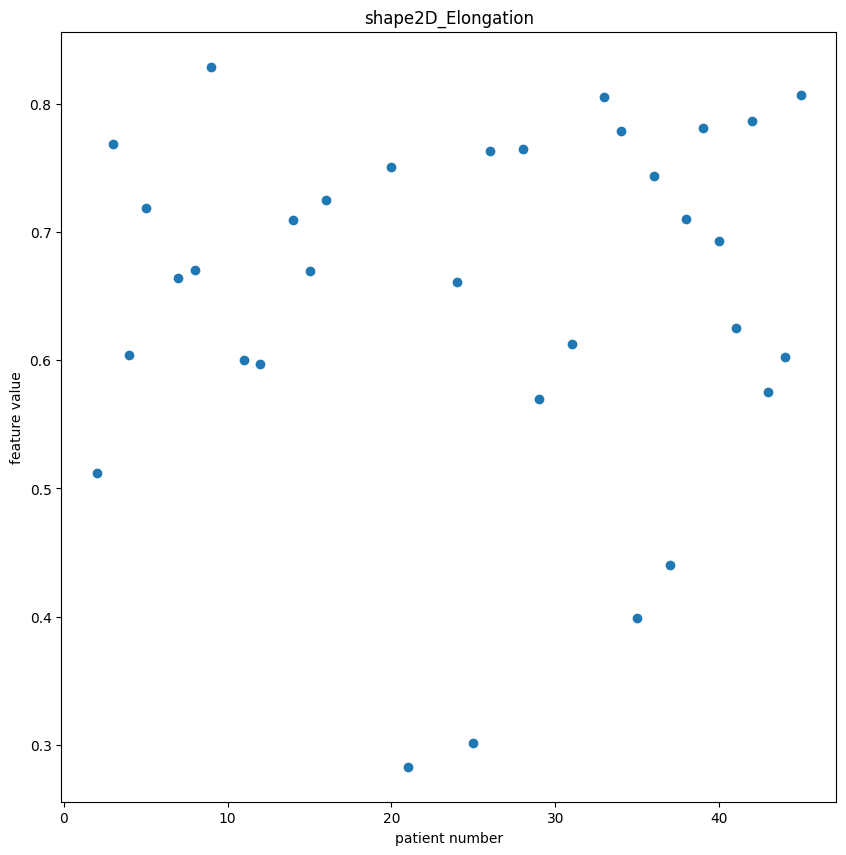

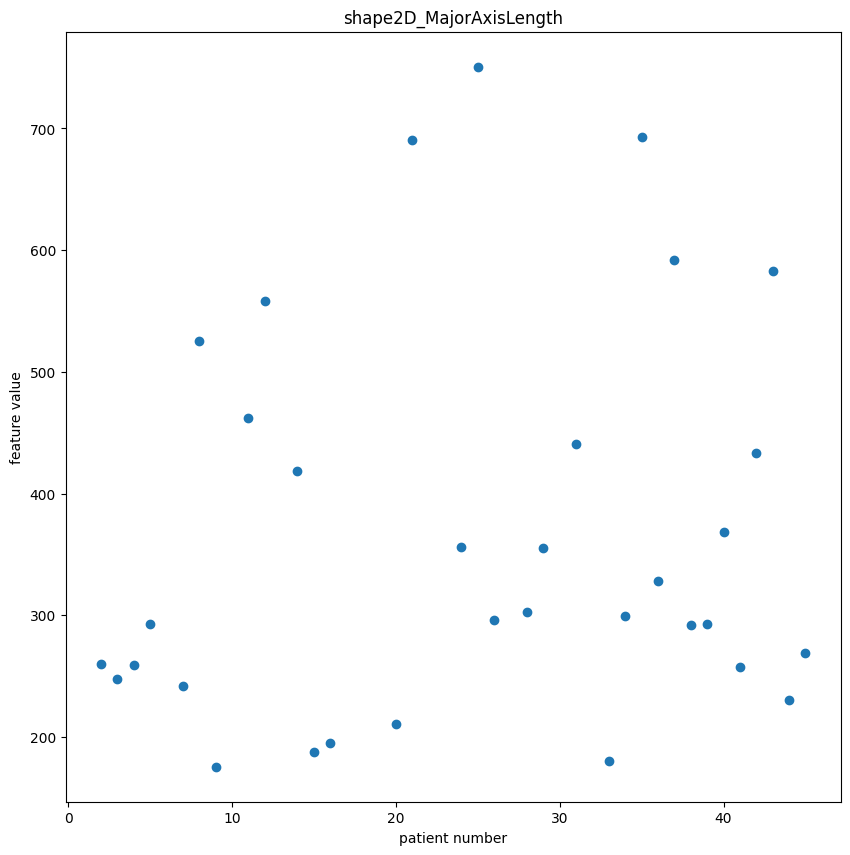

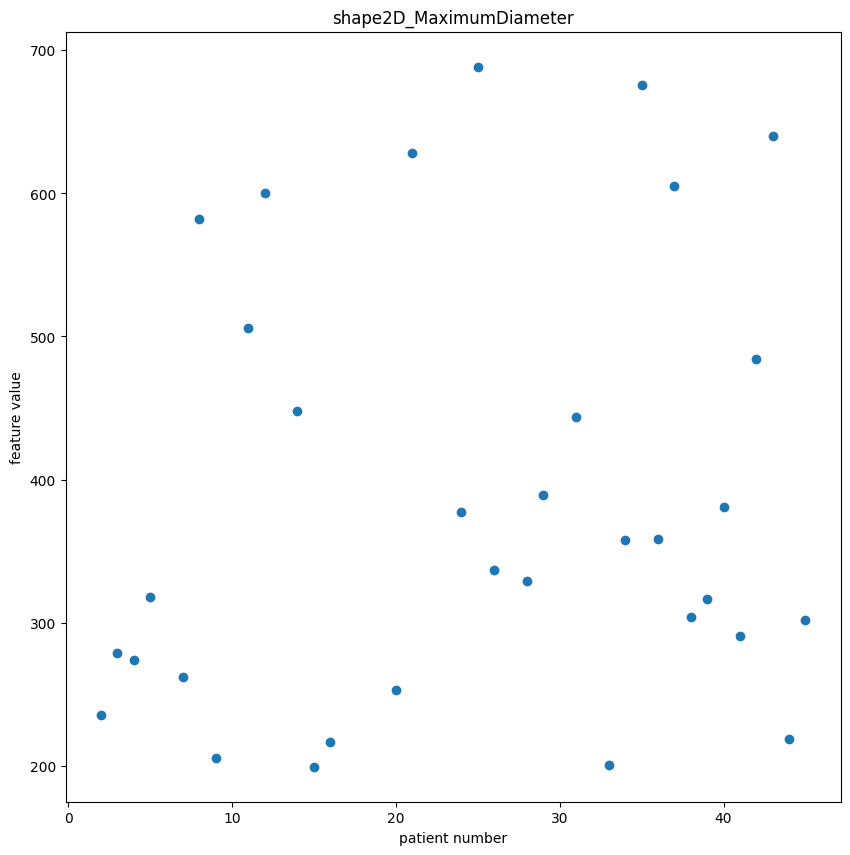

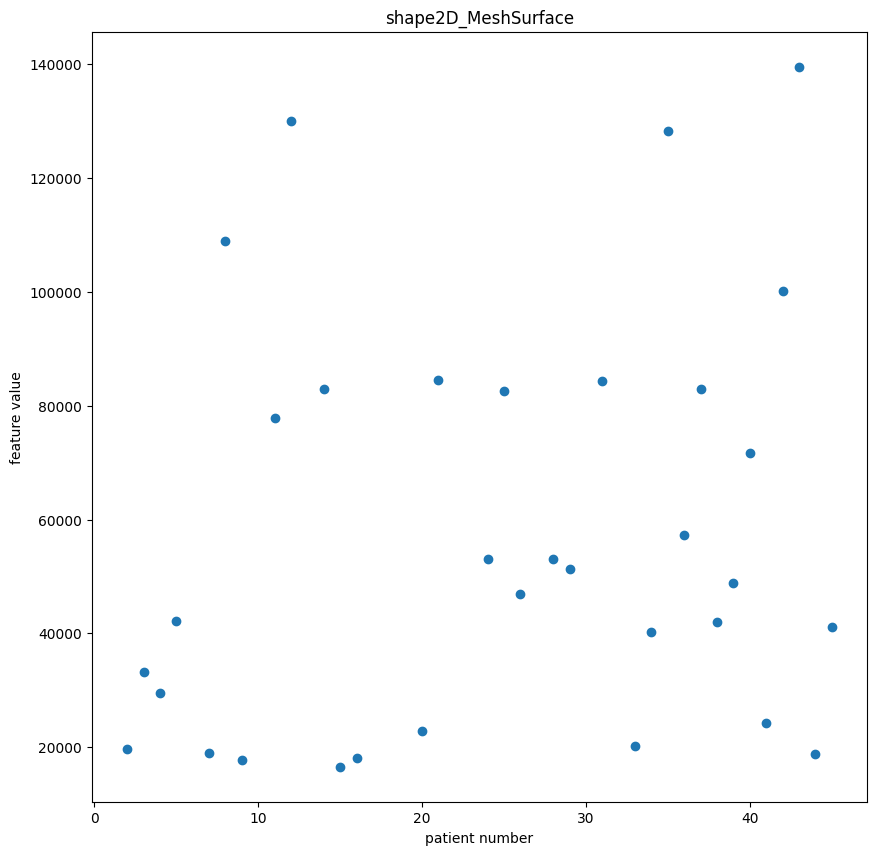

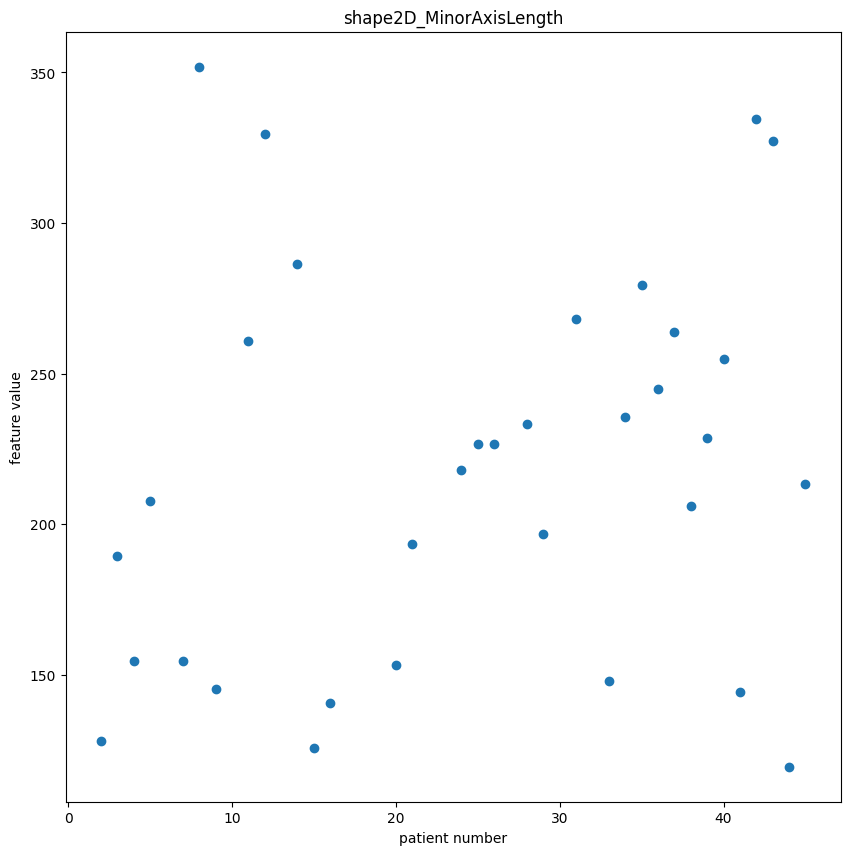

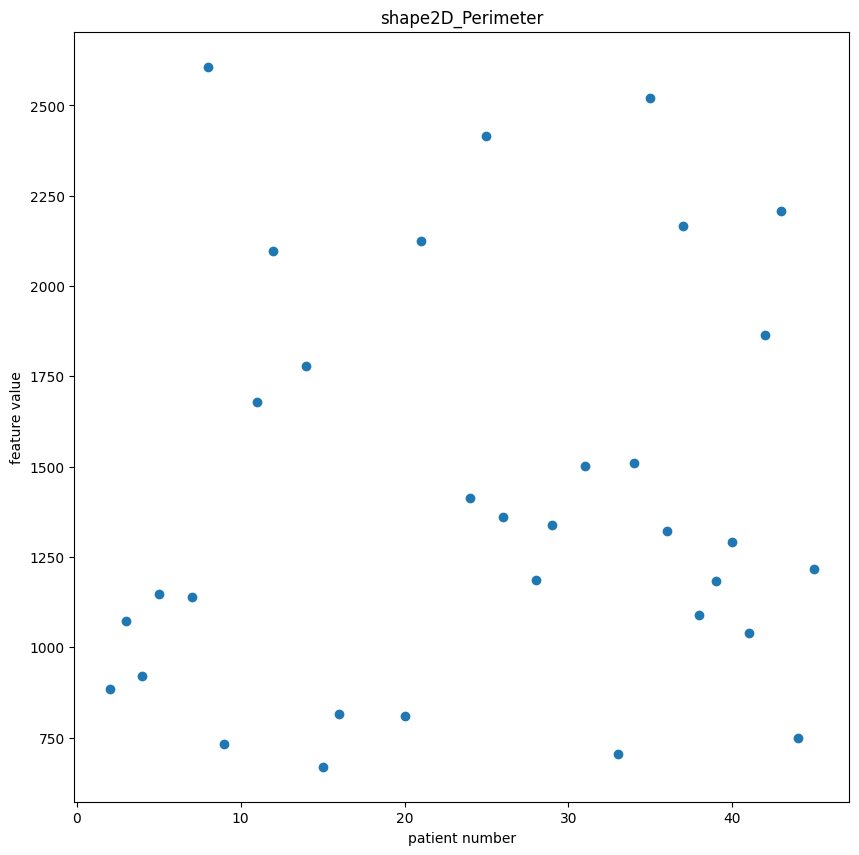

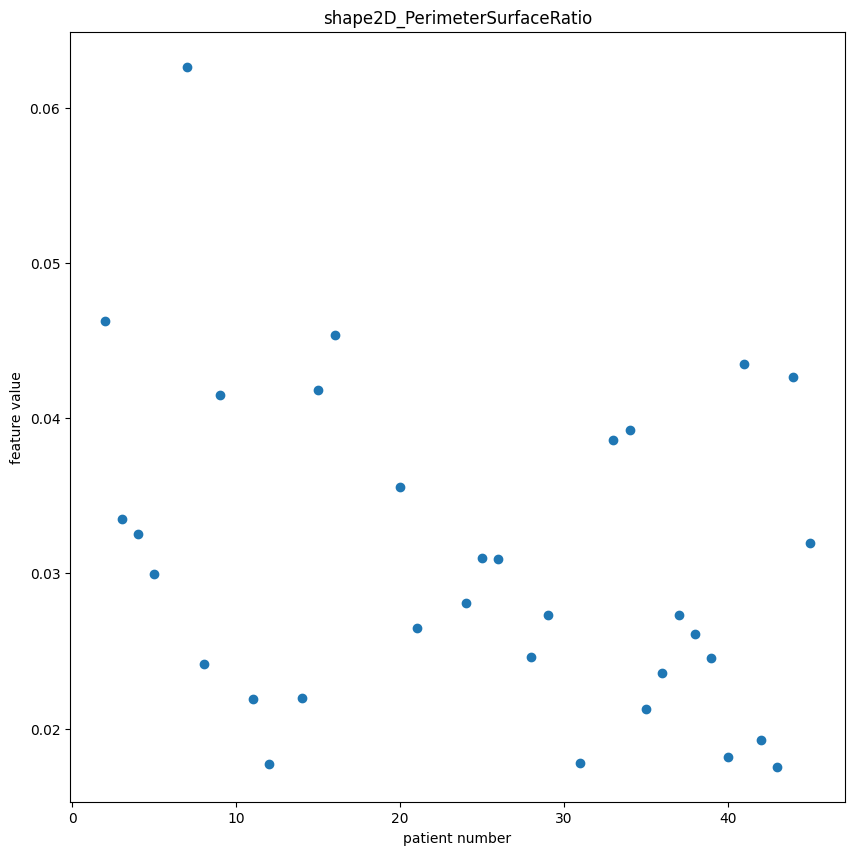

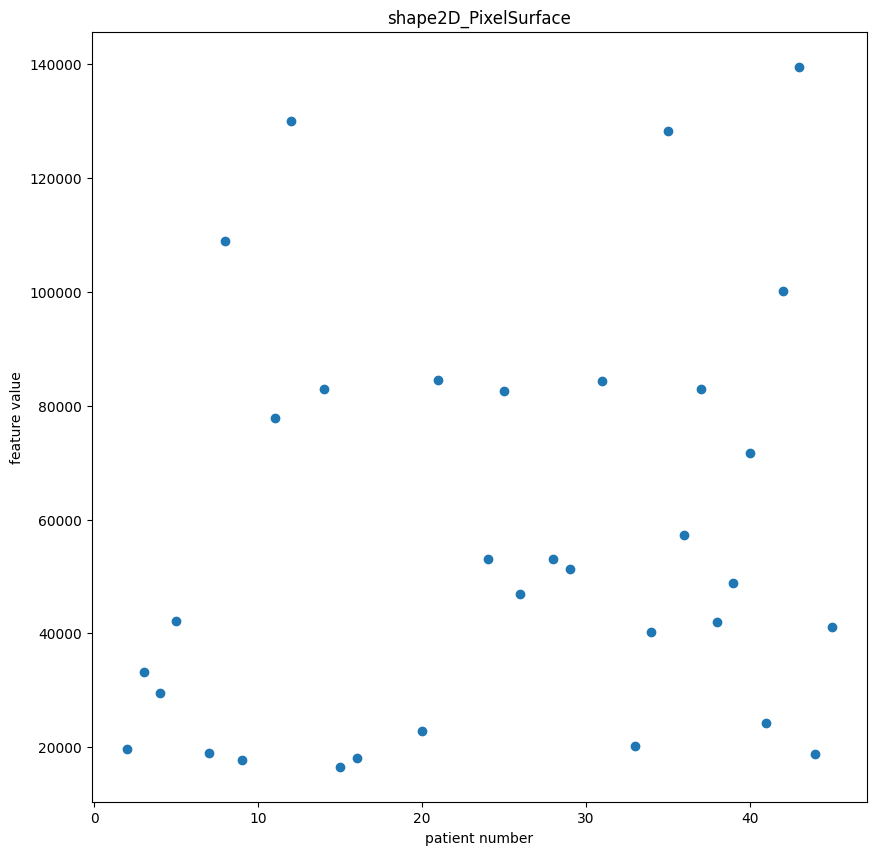

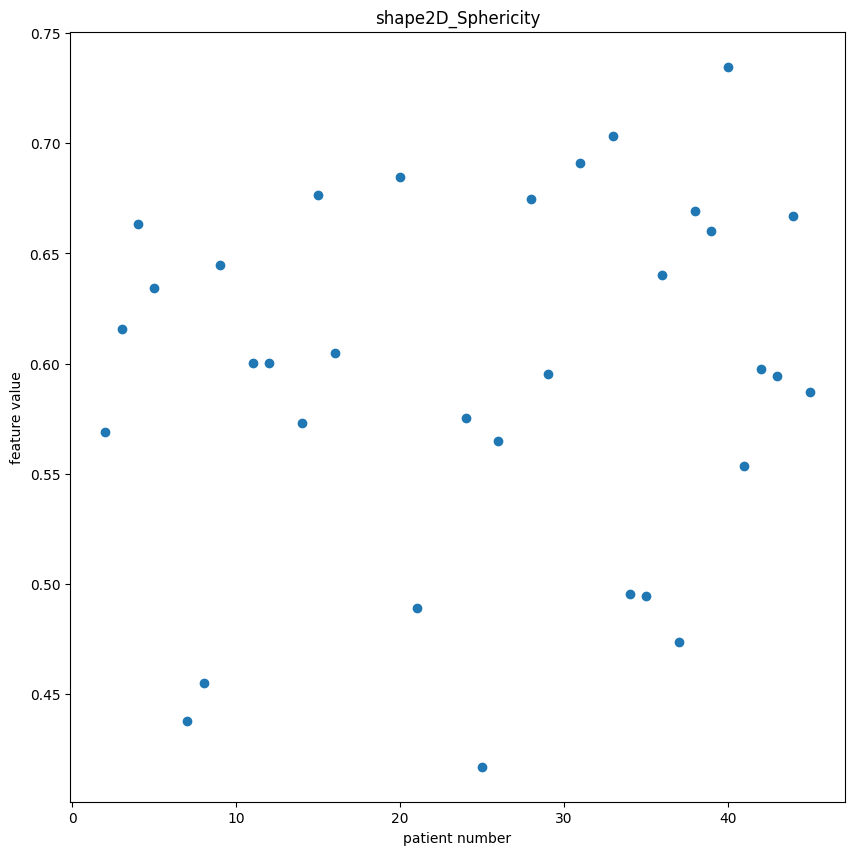

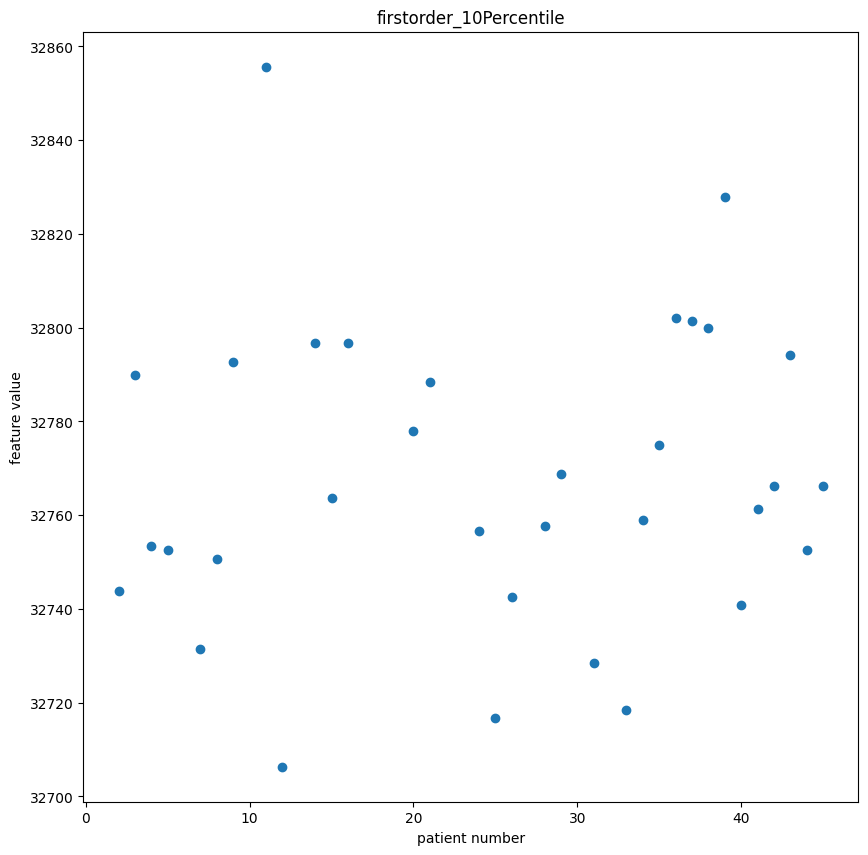

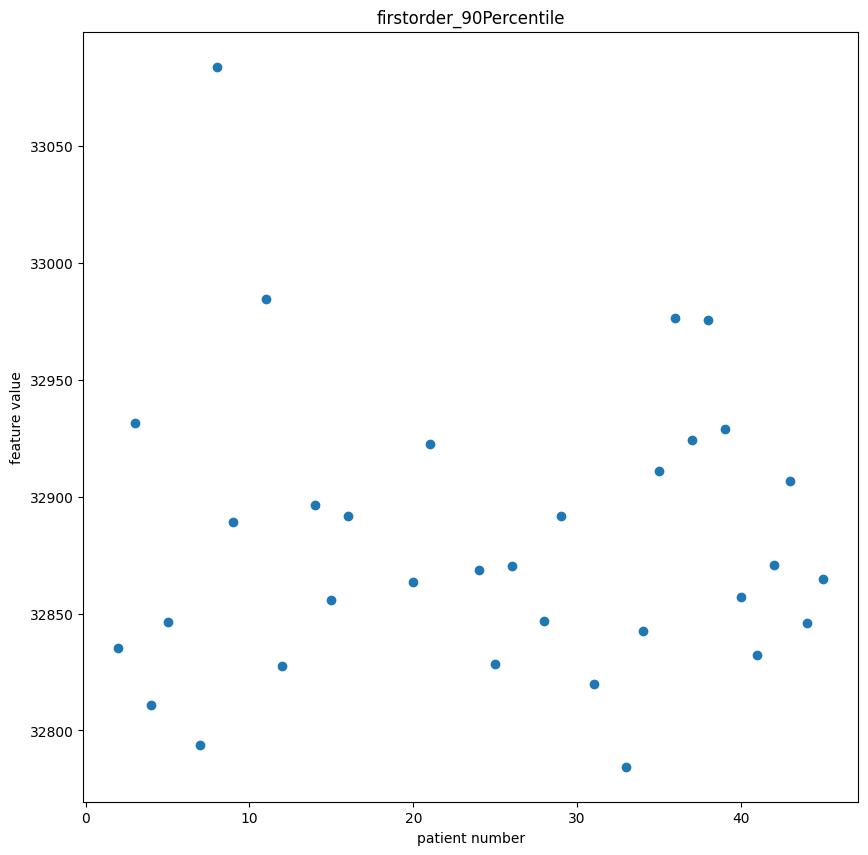

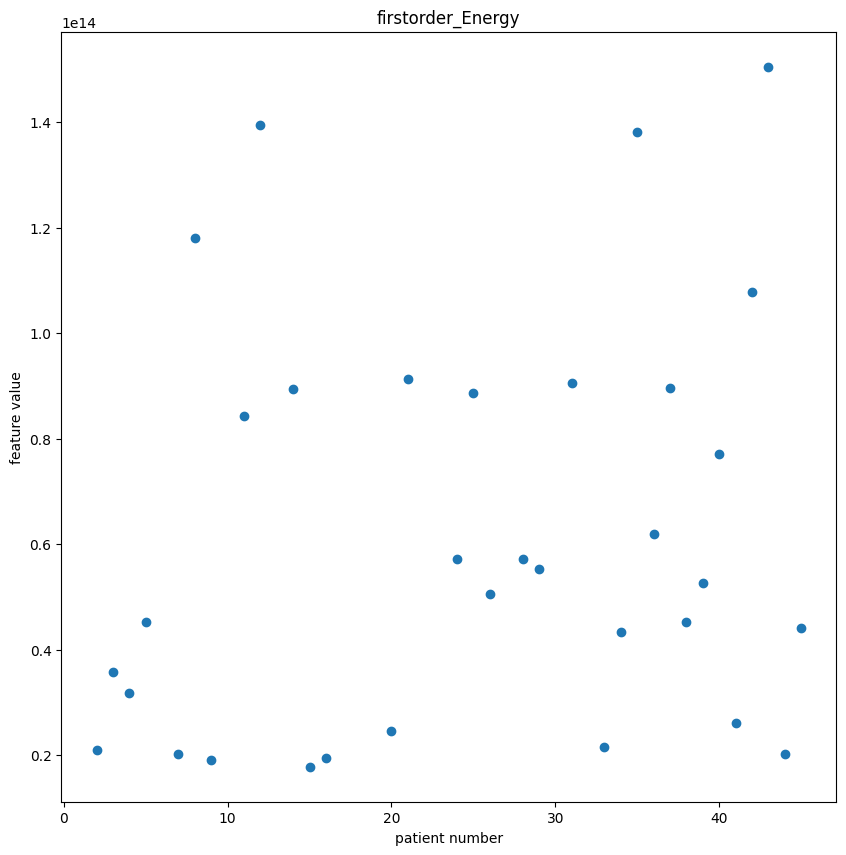

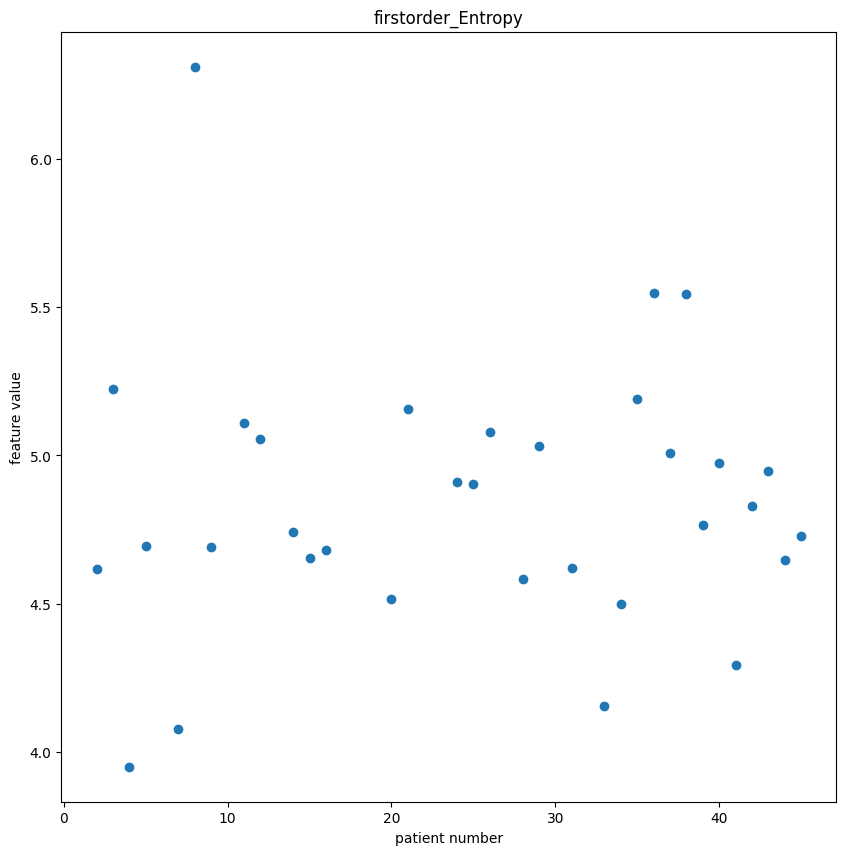

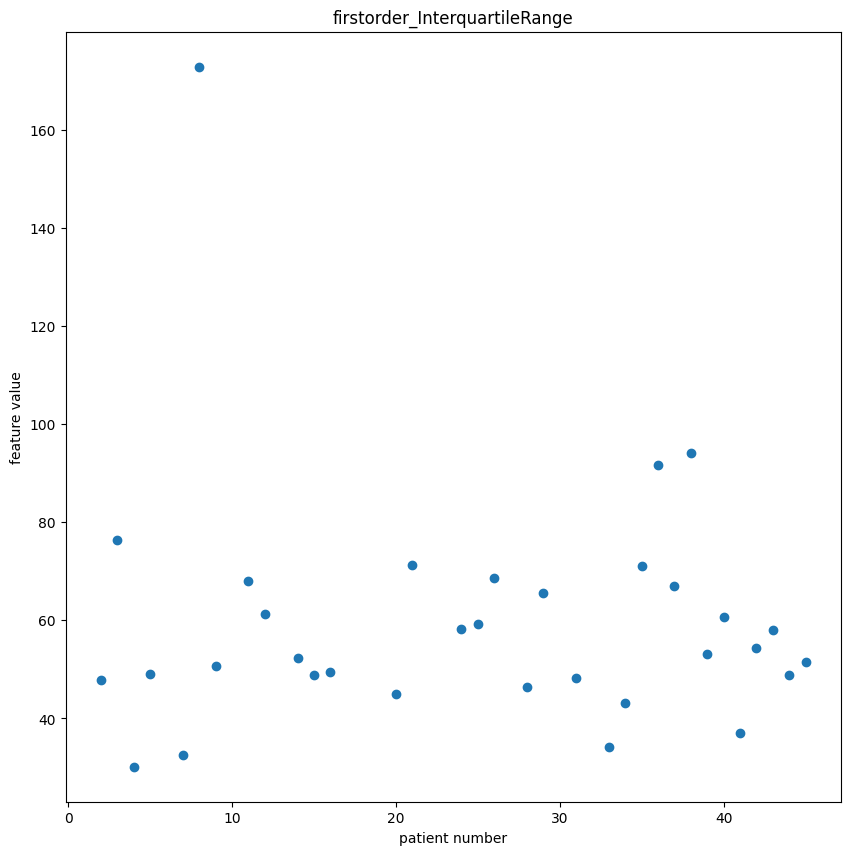

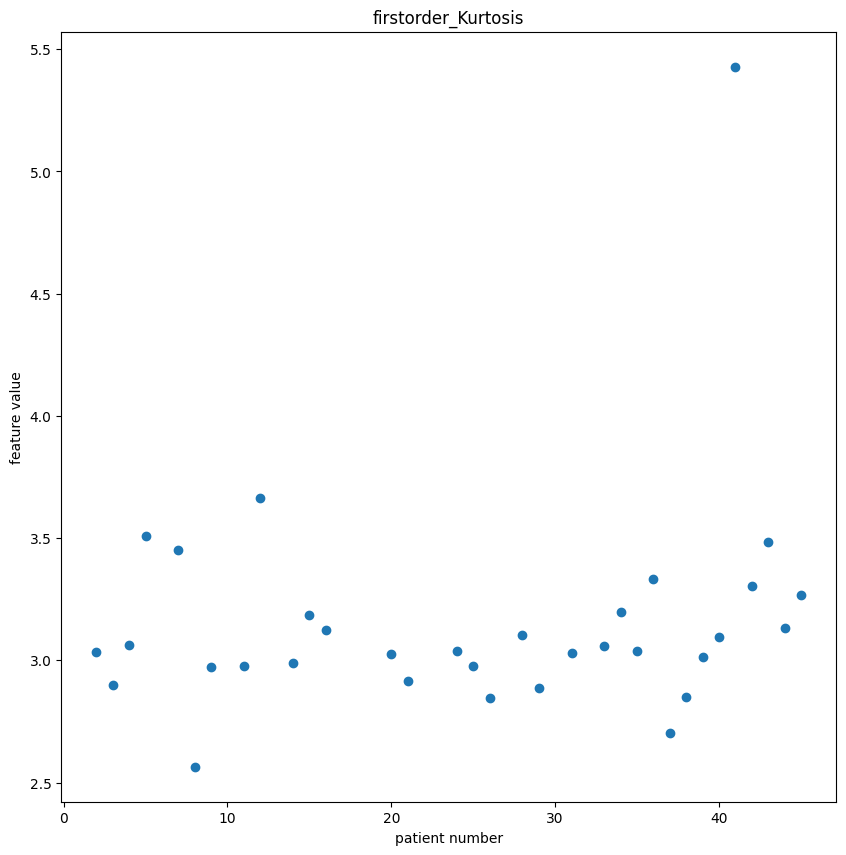

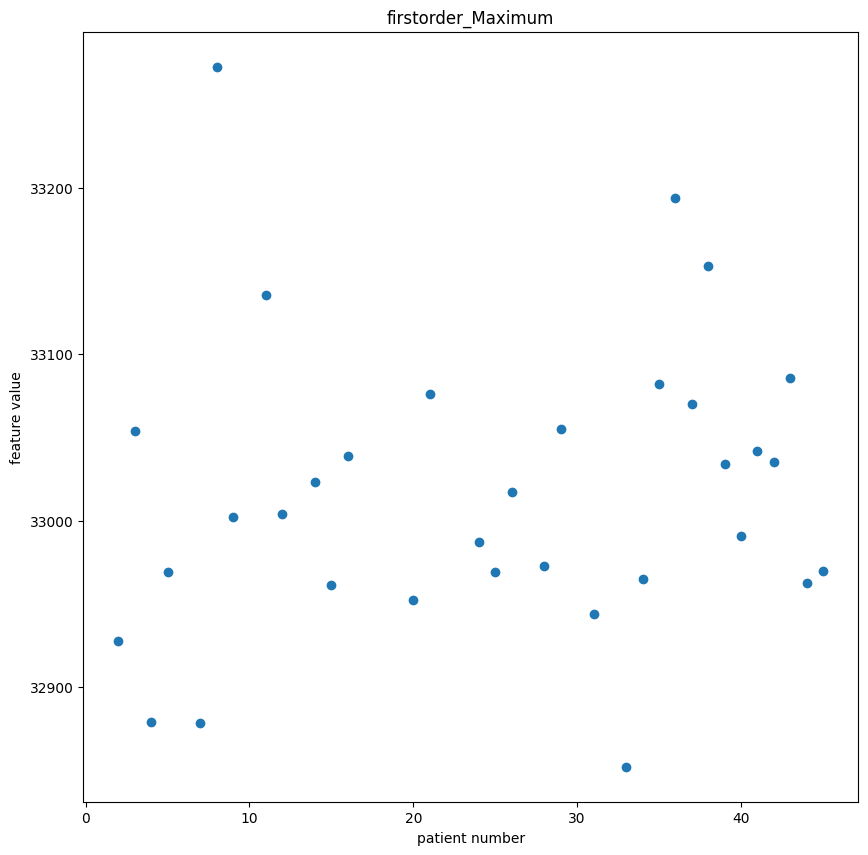

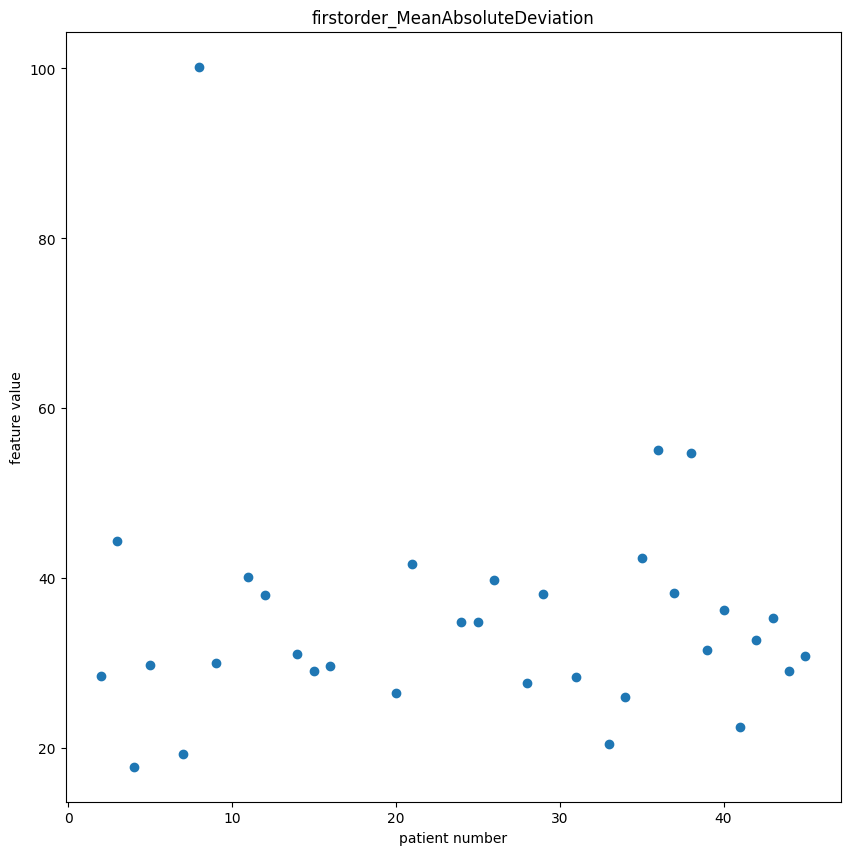

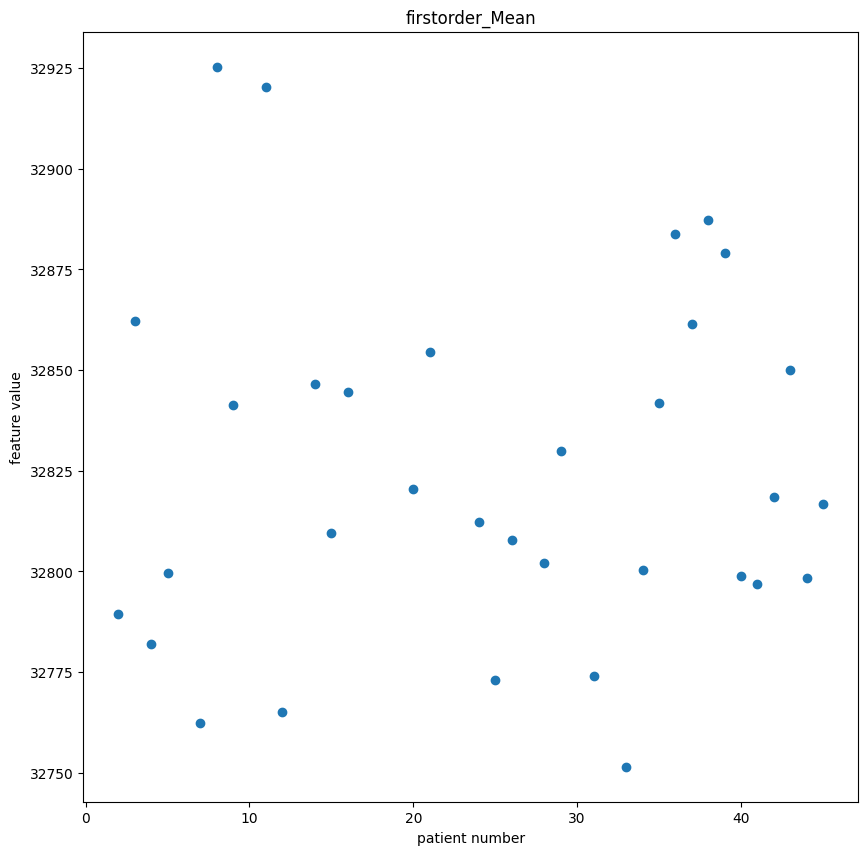

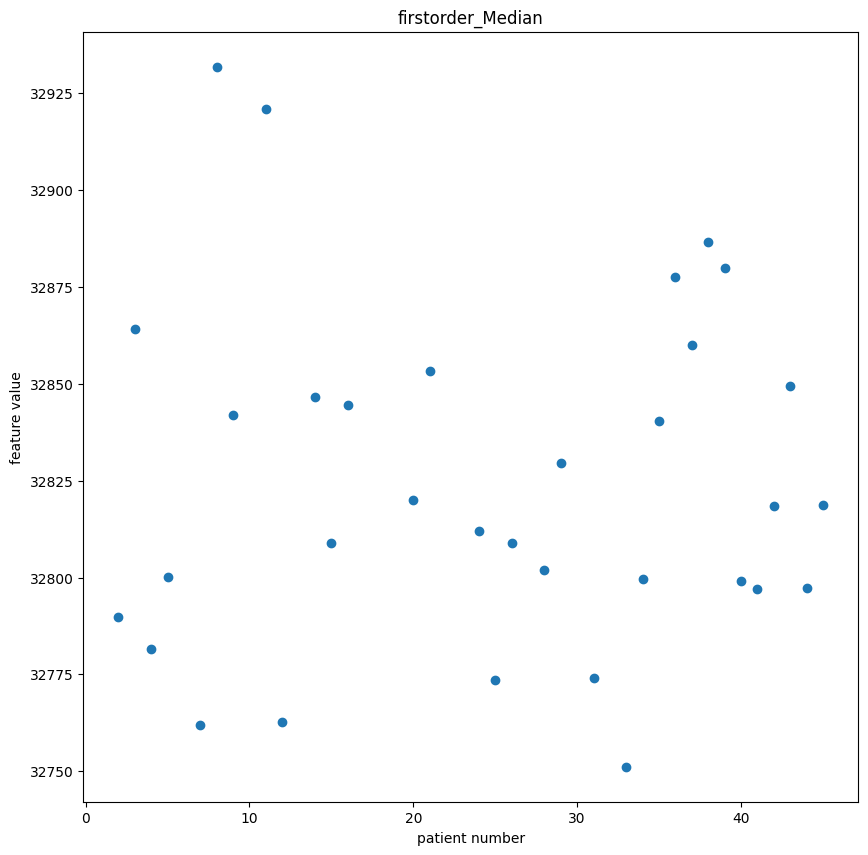

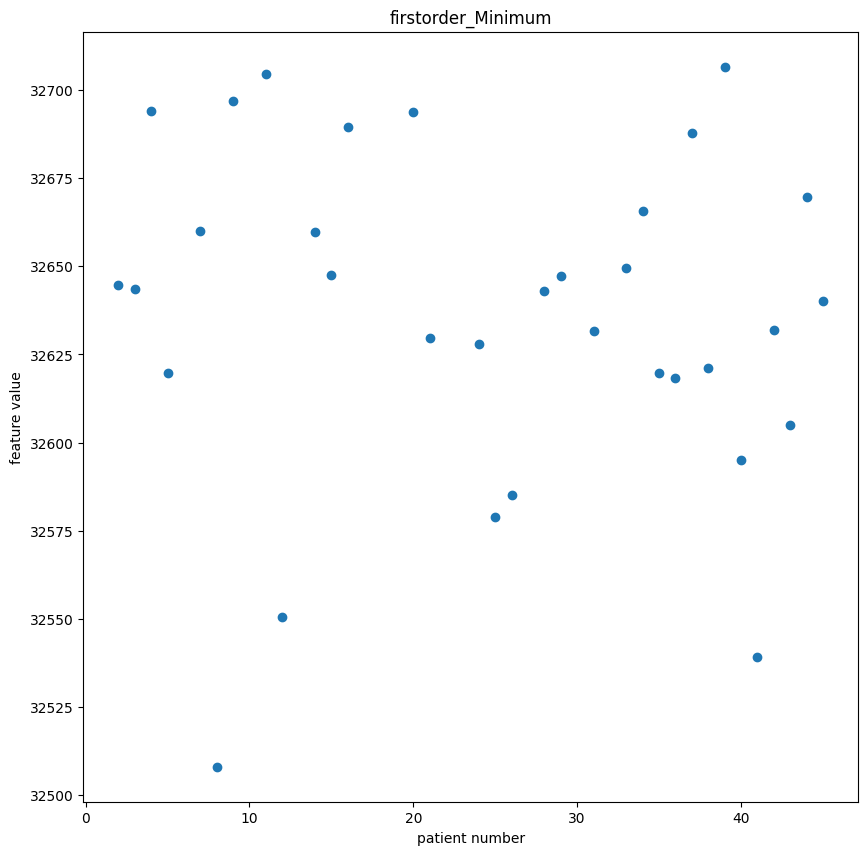

In [27]:
# read feat_vector
feat_vector = pd.read_csv(repo_path / 'data/features/feat_vector.csv', index_col=0)

# plot
for key in feat_vector.keys()[:20]:
    plt.figure(figsize=(10,10))
    plt.title(key)
    plt.plot(feat_vector[key], 'o')
    plt.xlabel('patient number')
    plt.ylabel('feature value')